In [1]:
import d2l 
from mxnet import autograd, gluon, init, np, npx
from mxnet.gluon import nn
npx.set_np()

In [2]:
net = nn.Sequential()
net.add(nn.Conv2D(channels= 6, kernel_size= 5, padding= 2, activation= 'sigmoid'),
       nn.AvgPool2D(pool_size= 2, strides= 2),
       nn.Conv2D(channels= 16, kernel_size= 5, activation= 'sigmoid'),
       nn.AvgPool2D(pool_size= 2, strides= 2),
       nn.Dense(120, activation= 'sigmoid'),
       nn.Dense(84, activation= 'sigmoid'),
       nn.Dense(10))

In [3]:
X = np.random.uniform(size= (1,1,28,28))
net.initialize()
for layer in net:
    X = layer(X)
    print(layer.name, 'output shape: \t', X.shape)

conv0 output shape: 	 (1, 6, 28, 28)
pool0 output shape: 	 (1, 6, 14, 14)
conv1 output shape: 	 (1, 16, 10, 10)
pool1 output shape: 	 (1, 16, 5, 5)
dense0 output shape: 	 (1, 120)
dense1 output shape: 	 (1, 84)
dense2 output shape: 	 (1, 10)


In [4]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size= batch_size)

In [5]:
def evaluate_accuracy_gpu(net, data_iter, ctx= None):
    if not ctx:
        ctx = list(net.collect_params().values())[0].list_ctx()[0]
    metric = d2l.Accumulator(2)
    
    for X, y in data_iter:
        X, y = X.as_in_ctx(ctx), y.as_in_ctx(ctx)
        metric.add(d2l.accuracy(net(X), y), y.size)
    
    return metric[0] / metric[1]

In [8]:
def train_ch6(net, train_iter, test_iter, num_epochs, lr, ctx= d2l.try_gpu()):
    net.initialize(force_reinit= True, ctx=ctx, init= init.Xavier())
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr})
    animator = d2l.Animator(xlabel= 'epoch', xlim= [0, num_epochs],
                           legend= ['train_loss', 'train_acc', 'test_acc'])
    
    timer = d2l.Timer()
    
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            
            X,y = X.as_in_ctx(ctx), y.as_in_ctx(ctx)
            with autograd.record():
                y_hat = net(X)
                l = loss(y_hat, y)
            l.backward()
            trainer.step(X.shape[0])
            metric.add(l.sum(), d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            
            train_loss, train_acc = metric[0] / metric[2], metric[1] / metric[2]
            
            if(i+1) % 50 == 0:
                animator.add(epoch+ i / len(train_iter),
                            (train_loss, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch+1, (None, None, test_acc))
        

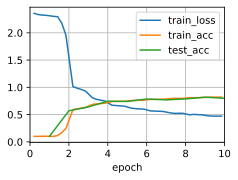

In [9]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr)
